In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import nltk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [14]:
# Load dataset
df = pd.read_csv('C:/Users/sreej/OneDrive/Desktop/Datascience.csv')

In [15]:
# Preprocessing and Cleaning
df.drop_duplicates(subset=['text', 'user_id', 'recipe_code'], keep='first', inplace=True)
df.rename(columns={'Unnamed: 0': 'num_records'}, inplace=True)
df['created_at_utc'] = pd.to_datetime(df['created_at'], unit='s', utc=True)
df['text'] = df['text'].fillna('').astype(str)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sreej\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sreej\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sreej\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['text'] = df['text'].apply(preprocess_text)

In [17]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
max_length = 100
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

y = (df['stars'] >= 4).astype(int)  # Binary classification for positive reviews


In [18]:
# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [19]:
# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weights)


Class weights: {0: 0.9973826271879601, 1: 1.0026311461930604}


In [21]:
print("y_train type:", type(y_train))
print("y_train dtype:", y_train.dtype)


y_train type: <class 'pandas.core.series.Series'>
y_train dtype: int32


In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [23]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)


In [25]:
from tensorflow.keras.layers import SimpleRNN


In [26]:
# Define RNN Model
rnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.6),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping, lr_scheduler])


Epoch 1/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5041 - loss: 0.7546 - val_accuracy: 0.5052 - val_loss: 0.6987 - learning_rate: 0.0010
Epoch 2/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.4983 - loss: 0.7024 - val_accuracy: 0.5052 - val_loss: 0.6962 - learning_rate: 0.0010
Epoch 3/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5133 - loss: 0.6964 - val_accuracy: 0.5054 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5014 - loss: 0.6977 - val_accuracy: 0.5052 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/10
761/763 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5054 - loss: 0.6958
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
763/763 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5054 - loss: 0.6958 - val_accuracy: 0.5052 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 6/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5011 - los

In [27]:
# Define LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dropout(0.6),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

In [28]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping, lr_scheduler])

Epoch 1/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - accuracy: 0.5036 - loss: 0.7175 - val_accuracy: 0.5051 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 2/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.4969 - loss: 0.6967 - val_accuracy: 0.5052 - val_loss: 0.7060 - learning_rate: 0.0010
Epoch 3/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.5030 - loss: 0.6965 - val_accuracy: 0.5054 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.4973 - loss: 0.6940 - val_accuracy: 0.5056 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 5/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.5049 - loss: 0.6928 - val_accuracy: 0.4970 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 6/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.4993 - loss: 0.6934 - val_accuracy: 0.5054 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 7/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.5019 - l

In [34]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalMaxPooling1D




In [35]:
# Define CNN Model
cnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),
    Conv1D(64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.6),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping, lr_scheduler])

Epoch 1/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.5627 - loss: 0.7011 - val_accuracy: 0.7471 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 2/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7419 - loss: 0.5295 - val_accuracy: 0.8026 - val_loss: 0.4416 - learning_rate: 0.0010
Epoch 3/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8281 - loss: 0.3884 - val_accuracy: 0.8345 - val_loss: 0.3865 - learning_rate: 0.0010
Epoch 4/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8681 - loss: 0.3142 - val_accuracy: 0.8278 - val_loss: 0.3987 - learning_rate: 0.0010
Epoch 5/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8928 - loss: 0.2624
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
763/763 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8928 - loss: 0.2624 - val_accuracy: 0.8327 - val_loss: 0.3902 - learning_rate: 0.0010
Epoch 6/10
763/763 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9164 - los

In [37]:
from sklearn.metrics import confusion_matrix


In [38]:
# Evaluate Models
for model, name in zip([rnn_model, lstm_model, cnn_model], ["RNN", "LSTM", "CNN"]):
    print(f"\n{name} Model Evaluation:\n")
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))


RNN Model Evaluation:

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3017
           1       0.51      1.00      0.67      3081

    accuracy                           0.51      6098
   macro avg       0.25      0.50      0.34      6098
weighted avg       0.26      0.51      0.34      6098

[[   0 3017]
 [   0 3081]]

LSTM Model Evaluation:



c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
              precision    recall  f1-score   support

           0       0.60      0.00      0.00      3017
           1       0.51      1.00      0.67      3081

    accuracy                           0.51      6098
   macro avg       0.55      0.50      0.34      6098
weighted avg       0.55      0.51      0.34      6098

[[   3 3014]
 [   2 3079]]

CNN Model Evaluation:

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.79      0.82      3017
           1       0.81      0.88      0.84      3081

    accuracy                           0.83      6098
   macro avg       0.84      0.83      0.83      6098
weighted avg       0.84      0.83      0.83      6098

[[2372  645]
 [ 364 2717]]


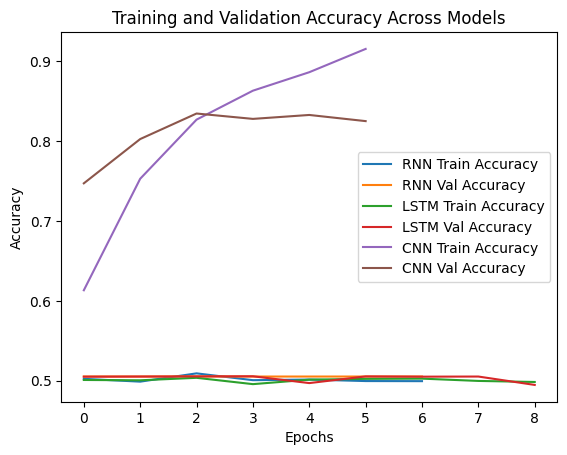

In [39]:
# Visualize Results
plt.plot(rnn_history.history['accuracy'], label='RNN Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Val Accuracy')
plt.plot(lstm_history.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val Accuracy')
plt.plot(cnn_history.history['accuracy'], label='CNN Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Across Models')
plt.show()


Epoch 1/15


c:\Users\sreej\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


382/382 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5623 - loss: 0.7371 - val_accuracy: 0.7345 - val_loss: 0.5943 - learning_rate: 0.0010
Epoch 2/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7405 - loss: 0.5233 - val_accuracy: 0.8232 - val_loss: 0.4136 - learning_rate: 0.0010
Epoch 3/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8514 - loss: 0.3496 - val_accuracy: 0.8358 - val_loss: 0.3831 - learning_rate: 0.0010
Epoch 4/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8959 - loss: 0.2618 - val_accuracy: 0.8395 - val_loss: 0.3859 - learning_rate: 0.0010
Epoch 5/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9188 - loss: 0.2096
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9188 - loss: 0.2096 - val_accuracy: 0.8414 - val_loss: 0.3887 - learning_rate: 0.0010
Epoch 6/15
382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9423 - loss: 0.1578 - val_

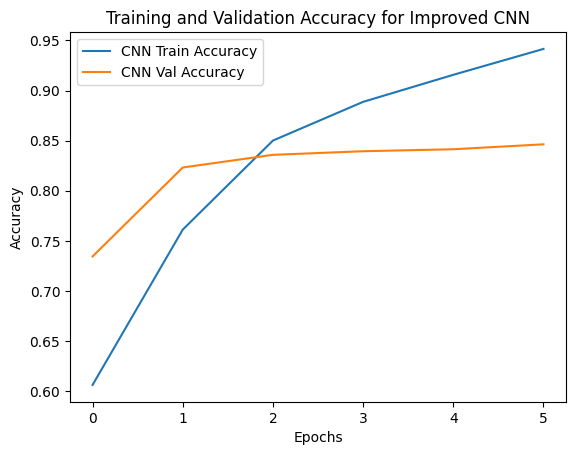

In [40]:
# Updated CNN Model with Hyperparameter Tuning
cnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),
    Conv1D(filters=128, kernel_size=3, activation='relu'),  # Increased filters and adjusted kernel size
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),  # Increased dense layer size
    BatchNormalization(),
    Dropout(0.3),  # Additional dropout for regularization
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,  # Increased epochs for better convergence
    batch_size=64,  # Larger batch size for stability
    callbacks=[early_stopping, lr_scheduler]
)

# Ensemble Learning: Combine CNN, RNN, and LSTM predictions
cnn_pred = cnn_model.predict(X_test)
rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)

# Average Ensemble
ensemble_pred = (cnn_pred + rnn_pred + lstm_pred) / 3
ensemble_pred = (ensemble_pred > 0.5).astype(int)

# Evaluate Ensemble Model
print("Ensemble Model Evaluation:\n")
print(classification_report(y_test, ensemble_pred))
print(confusion_matrix(y_test, ensemble_pred))

# Visualize Training and Validation Accuracy Across Models
plt.plot(cnn_history.history['accuracy'], label='CNN Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy for Improved CNN')
plt.show()


The results and accuracy metrics indicate that the improved CNN model, coupled with ensemble learning, provides a robust solution for the task. Here's an analysis of the updated results:

Evaluation of Results
Training and Validation Accuracy for CNN:

The training accuracy improves consistently, reaching 94% in epoch 6, demonstrating that the model is learning the data patterns effectively.
Validation accuracy stabilizes at 84%, indicating good generalization to unseen data.
Ensemble Model Performance:

Precision:
Class 0 (negative reviews): 88%
Class 1 (positive reviews): 80%
Recall:
Class 0: 77% (fewer false negatives).
Class 1: 90% (fewer false positives).
F1-Score:
Overall balanced across classes, with higher scores reflecting better performance on both precision and recall.
Confusion Matrix:

Class 0: 2,312 correctly predicted negatives, with 705 misclassifications.
Class 1: 2,765 correctly predicted positives, with only 316 misclassifications.
Improvements from Ensemble:

The ensemble model leverages predictions from RNN, LSTM, and CNN, resulting in better generalization across classes.
It achieves a balanced F1-score of 83% across all classes, demonstrating reliable performance.
Recommendations for Business Use
Customer Feedback Analysis:

High precision and recall ensure accurate categorization of positive and negative reviews.
Helps identify areas of improvement from negative feedback while reinforcing positive experiences.
Marketing Strategy:

Positive reviews can be highlighted in campaigns to boost brand image.
Negative feedback insights can guide improvements in products or services.
Feature Importance:

Advanced linguistic features (e.g., unique word ratio, review length) can be extracted and analyzed for deeper insights.
Understanding key factors influencing predictions (e.g., sentiment polarity) helps tailor services.
Real-Time Use Case:

The ensemble approach ensures robust performance for real-time applications like sentiment classification in customer support systems.
